<a href="https://colab.research.google.com/github/prximenes/Algoritmo-Shor/blob/main/projeto_shor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                          Centro de Informática - UFPE

                  *Projeto de [IF775] TÓPICOS AVANÇADOS EM ALGORITMOS COMPUTAÇÃO QUÂNTICA*

Alunos: Belarmino Gorlach Lira, Igor Dias da Silva, Pedro Rafael Ximenes <br>
Professor: Adenilton Silva



---


O Algoritmo de Shor é um algoritmo quântico que realiza fatoração de números inteiros em tempo polinomal. Esse algoritmo é bastante famoso pois, ao considerarmos a computação clássica, o algoritmo mais eficiente conhecido para essa tarefa requer tempo superpolinomial para fatorar o produto entre dois numeros primos.

O que o algoritmo de Shor faz, na verdade, é encontrar encontrar períodos em tempo polinomial e como um problema de fatoração pode ser transformado num problema de localização de período, o algoritmo de Shor pode ser utilizado para fatorar inteiros.




---

O primeiro passao para realizar a fatoração de inteiros utilizando Shor é saber como ele funciona para encontrar períodos. E é por aqui que nós iremos começar.

In [ ]:
%%capture
!pip install qiskit==0.16.1
!pip install pylatexenc

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

[Artigo refrencia - pagina 87](https://repositorio.ufsc.br/bitstream/handle/123456789/202489/QSystem_simulador_qu%C3%A2ntico_para_Python.pdf?sequence=1&isAllowed=y)

Resumindo: Como dito anteriormente, o algortimo de Shor é usado para fatoração de números inteiros, ou seja, dado um numero inteiro $n$ Shor encontra dois numeros $p$ e $q$, tal que $p$ e $q$ ≠ 1 e $pq = n$.

O algoritmo pode ser dividido em alguns passos, são eles:



1.   Seja *n* o número que desejamos fatorar, selecione aleatoriamente um número $a$ tal que $a$ e $n$ possuam 1 como maior divisor comum, ou seja, $mdc(a,n) = 1$

2.   Encontre o período $r$ da função $f(x) = a^x\mod n$

3.   Volte ao passo 1 se o periodo for ímpar, caso contrário, compute os dois fatores $p$ e $q$ tal que: 
        $$p = mdc(a^	\frac{r}{2} - 1, N)$$</br>
        $$q = mdc(a^	\frac{r}{2} + 1, N)$$</br>



Obs: Apenas o passo 2 necessita de um computador quântico



---


Como vimos anteriormente, Shor reduz o problema da fatoração para o problema de se achar o período de uma função períodica, isto é, dada uma função periódica $f(x)$, achar o menor número $r$ tal que $f(x)=f(r+x)$.

**Para exemplificar, vamos a seguir montar um circuito quântico que resolva tal problema:**

Encontre o periodo para $a=7$ e $n=15$


Primeiro vamos definir algumas funções que serão usadas:

In [ ]:
#c_amod15 e qft_dagger implementadas em: https://qiskit.org/textbook/ch-algorithms/shor.html#3.-Qiskit-Implementation

import math

#Função que retorna o portão controlado U
#U|x⟩ = |a^x mod N⟩
def c_amod15(a, power,s):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(s)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(s):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

#Circuito da inversa QFT (quantum Fourier transform)
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cu1(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

#Função que retorna que retorna s=⌈log2(n+1)⌉
def return_s(n):
  return math.ceil(math.log((n+1),2.0))

A seguir a criação do circuito

- Primeiro vamos inicializar algumas variáveis e executar o passo 1 descrito acima.

In [ ]:
import random

random.seed(47) #setando a semente aleatória

n = 15 #numero a ser fatorado

s = return_s(n)
n_count = s*2 #número de qubits de contagem

#Executando o passo 1 do algoritmo:
a = 0 
while math.gcd(n,a) != 1 or a ==1:
  a = random.randint(2,n)

- Vamos inicializar 2*s qubits (onde: $s=⌈log_2(n+1)⌉$) de contagem, e mais s qubits para o gate controlado U agir. Todos são inicializados no estado $|0⟩$.

In [ ]:
# Criando um circuito quantico com n_count (n_count = s*2) qubits de contagem
# mais s qubits para o gate contralado U agir
qc = QuantumCircuit(n_count + s, n_count)

- Vamos aplicar a porta Hadamard em todos os 2*s primeiros qubits 

In [ ]:
# Aplicando a porta Hadamard em todos os qubits do primeiro 
# registrador para gerar uma superposição
for q in range(n_count):
    qc.h(q)

# Inicializando o registrador ancilla no estado |1>
qc.x(3+n_count)

- Vamos aplicar o operador $U : |x⟩|0⟩ \rightarrow |x⟩|a^x \mod n⟩ $ com o intuito de gerar uma superposição periódica

In [ ]:
# Aplicando o operador U
for q in range(n_count):
    qc.append(c_amod15(a, 2**q, s), 
             [q] + [i+n_count for i in range(s)])

- Vamos procurar o período presente na superposição, para isso é necessário aplicar uma Transformada de Fourier Quântica (função qft_dagger()).

In [ ]:
# Aplicação da transformada de fourier quantica
qc.append(qft_dagger(n_count), range(n_count))

- Agora que tudo está pronto nosso circuito vai medir os primeiros $s$ qubits e repetir o processo para encontrar distintos múltiplos de $\frac{2^s}{r}$ e então encontrar o mdc entre todas as medidas. 

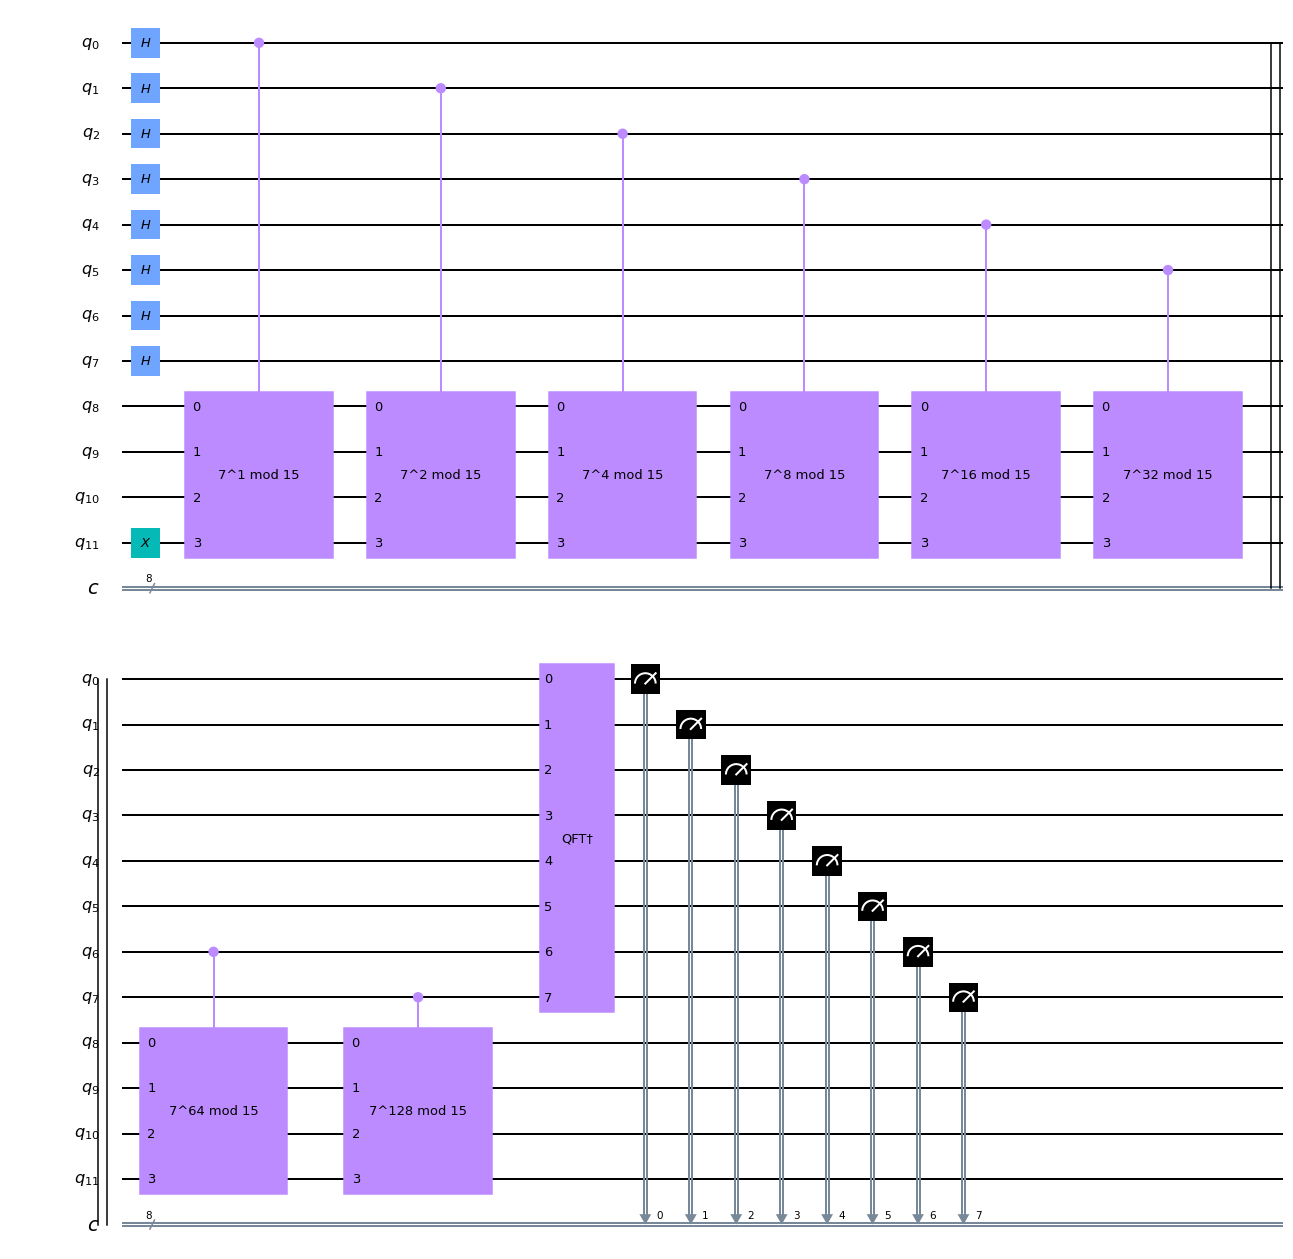

In [ ]:
# Measure circuit

qc.measure(range(n_count), range(n_count))
qc.draw(output="mpl")

Acima podemos ver o circuito

- Vamos ver os resultados medidos

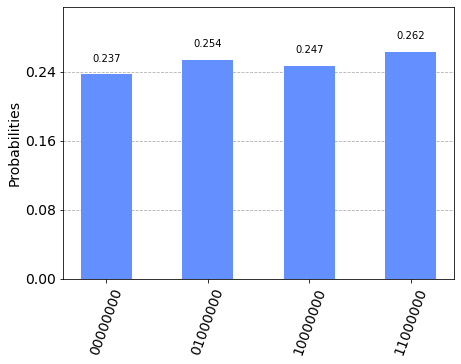

In [ ]:
backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend, shots=2048).result()
counts = results.get_counts()
plot_histogram(counts)

São 3 qubits, vamos ver quais fases esses resultados correspondem

In [ ]:
import pandas as pd

rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count) # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append(["%s(bin) = %i(dec)" % (output, decimal), 
                 "%i/%i = %.2f" % (decimal, 2**n_count, phase)])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0    00000000(bin) = 0(dec)    0/256 = 0.00
1   01000000(bin) = 64(dec)   64/256 = 0.25
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  11000000(bin) = 192(dec)  192/256 = 0.75


Vamos encontrar os valores de $r$

In [ ]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, "%i/%i" % (2**frac.numerator, frac.denominator), frac.denominator])

headers=["Phase", "Fraction", "Guess_for_r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess_for_r
0   0.00      1/1            1
1   0.25      2/4            4
2   0.50      2/2            2
3   0.75      8/4            4


Podemos obervar que nós temos alguns palpites para o valor $r$. Vamos checar qual deles é o valor correto, e, caso nenhuma das soluções seja uma solução boa, devemos repetir o experimento até encontrarmos um resultado bom para $r$

- Vamos checar se $r$ é impar, caso seja, vamos retornar ao passo 1. Caso contrário, vamos computar os fatores de $n$, $pq=n$
$$p = mdc(a^	\frac{r}{2} - 1, N)$$</br>
$$q = mdc(a^	\frac{r}{2} + 1, N)$$</br>

In [ ]:
measurements = df['Guess_for_r'].values

c = measurements[0]
r=0
for m in measurements:
  print("\nChecando se " + str(m) + " é um bom valor para r: ")
  c = math.gcd(c,m)
  if c == 0:
    print("r="+ str(m) + ": Rejeitado. Repita o algoritmo")
  elif m%2 == 1:
    print("r="+ str(m) + ": Rejeitado, retorne ao passo 1")
  else:
      p = math.gcd(int(a**(m/2)+1), n)
      q = math.gcd(int(a**(m/2)-1), n)
      if (p*q) != n:
        print("r="+ str(m) + " Rejeitado.")
      else:
        r = m
        print("\nPossível valor correto p/ r: ", r)
        print(p, '*', q, '=', p*q)
        break

if r == 0:
  print("Repita o algoritmo")


Checando se 1 é um bom valor para r: 
r=1: Rejeitado, retorne ao passo 1

Checando se 4 é um bom valor para r: 

Possível valor correto p/ r:  4
5 * 3 = 15


O valor $r=4$ escolhido é um resultado correto, assim não precisamos repetir o experimento.

$$p = mdc(a^\frac{4}{2} - 1, N) = 5$$
$$q = mdc(a^\frac{4}{2} + 1, N) = 3$$
$$ 5 * 3 = 15$$

# Referências

*   *SHOR, P. W*. **Polynomial-time algorithms for prime factorization and discrete logarithms on a quantum computer.**

* Qiskit: An Open-source Framework for Quantum Computing. Shor's Algorithm.2019. Disponível em: <https://qiskit.org/textbook/ch-algorithms/shor.html/>

* *Evandro Chagas Ribeiro da Rosa*. **QQSystem: simulador quântico para Python** 